# BRIEF
IT NOW CAN PERFORM REGRESSION AND multi class CLASSIFICATION



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from core.nn import Linear,batchnorm1d,Conv2d,MaxPool2d
from core.Models import Model
from core.Function import tanh,relu,softmax

In [2]:


# Load Fashion MNIST dataset using Scikit-Learn
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
images, labels = fashion_mnist["data"], fashion_mnist["target"].astype(int)

# Normalize pixel values to the range [0, 1]
images = images.astype('float32') / 255.0

# Reshape images from (num_samples, 784) to (num_samples, 1, 28, 28)
images = images.reshape((-1, 28*28))  # Convert to 4D for Conv2D: [B, C, H, W]

# Split into train and test sets
train_images_2d, test_images_2d = images[:60000], images[60000:]
train_labels_2d, test_labels_2d = labels[:60000], labels[60000:]

# One-hot encode the labels
encoder = OneHotEncoder()
train_labels_2d = encoder.fit_transform(train_labels_2d.reshape(-1, 1)).toarray()
test_labels_2d = encoder.transform(test_labels_2d.reshape(-1, 1)).toarray()

# Print shapes to verify
print("Train images shape:", train_images_2d.shape)  # (60000, 784)
print("Train labels shape:", train_labels_2d.shape)  # (60000, 10)
print("Test images shape:", test_images_2d.shape)    # (10000, 784)
print("Test labels shape:", test_labels_2d.shape)    # (10000, 10)


Train images shape: (60000, 784)
Train labels shape: (60000, 10)
Test images shape: (10000, 784)
Test labels shape: (10000, 10)


In [3]:


# Load Fashion MNIST dataset using Scikit-Learn
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
images, labels = fashion_mnist["data"], fashion_mnist["target"].astype(int)

# Normalize pixel values to the range [0, 1]
images = images.astype('float32') / 255.0

# Reshape images from (num_samples, 784) to (num_samples, 1, 28, 28)
images = images.reshape((-1, 1, 28, 28))  # Convert to 4D for Conv2D: [B, C, H, W]

# Split into train and test sets
train_images, test_images = images[:60000], images[60000:]
train_labels, test_labels = labels[:60000], labels[60000:]

# One-hot encode the labels
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels = encoder.transform(test_labels.reshape(-1, 1)).toarray()

# Print shapes to verify
print("Train images shape:", train_images.shape)  # (60000, 1, 28, 28)
print("Train labels shape:", train_labels.shape)  # (60000, 10)
print("Test images shape:", test_images.shape)    # (10000, 1, 28, 28)
print("Test labels shape:", test_labels.shape)    # (10000, 10)


Train images shape: (60000, 1, 28, 28)
Train labels shape: (60000, 10)
Test images shape: (10000, 1, 28, 28)
Test labels shape: (10000, 10)


In [4]:
from core.nn import Linear,batchnorm1d,Conv2d,MaxPool2d
from core.Models import Model
from core.Function import tanh,relu,softmax
class model(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(input_channels=1, output_channels=8, kernel_size=3, stride=1, padding=1,initialize_type='xavier')
        self.tanh1 = tanh()
        self.max1 = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(input_channels=8, output_channels=16, kernel_size=3, stride=1, padding=1,initialize_type='xavier')
        self.tanh2 = tanh()
        self.max2 = MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = Linear((16 * 7 * 7,50),initialize_type='xavier')
        self.tanh3 = tanh()
        self.linear2 = Linear((50,10),initialize_type='xavier')
        self.softmaxx = softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.max2(x)
        x = self.linear1(x)
        x = self.tanh3(x)
        x = self.linear2(x)
        x = self.softmaxx(x)
        return x
    

model_coco = model()
model_coco.summary()	


Model Summary:
conv1: Conv2d
  Weights: (8, 1, 3, 3)
  Bias: (1, 8, 1, 1)
tanh1: tanh
max1: MaxPool2d
conv2: Conv2d
  Weights: (16, 8, 3, 3)
  Bias: (1, 16, 1, 1)
tanh2: tanh
max2: MaxPool2d
linear1: Linear
  Weights: (784, 50)
  Bias: (1, 50)
tanh3: tanh
linear2: Linear
  Weights: (50, 10)
  Bias: (1, 10)
softmaxx: softmax


In [5]:
model_coco.train(train_images, train_labels, epochs=10, batch_size=64, learning_rate=0.001, optimizer="sgd",verbose=1)

Epoch 1/10 | Epoch Loss = 2.0192
Epoch 2/10 | Epoch Loss = 1.3584
Epoch 3/10 | Epoch Loss = 1.0518
Epoch 4/10 | Epoch Loss = 0.9210
Epoch 5/10 | Epoch Loss = 0.8448
Epoch 6/10 | Epoch Loss = 0.7926
Epoch 7/10 | Epoch Loss = 0.7535
Epoch 8/10 | Epoch Loss = 0.7224
Epoch 9/10 | Epoch Loss = 0.6969
Epoch 10/10 | Epoch Loss = 0.6752

Function train took 461.4355 minutes to execute.


In [6]:
from core.utils import gradient_check
from core.loss import sparse_categorical_cross_entropy



gradient_check(model=model_coco,X=test_images[:1],Y=test_labels[:1],loss_fn=sparse_categorical_cross_entropy)

Layer Conv2d (Weights): Gradient Check PASSED (diff: 9.39281994e-09)
Layer Conv2d (Biases): Gradient Check PASSED (diff: 2.05376056e-09)

Layer Conv2d (Weights): Gradient Check PASSED (diff: 1.98739186e-08)
Layer Conv2d (Biases): Gradient Check PASSED (diff: 4.35862853e-09)

Layer Linear (Weights): Gradient Check PASSED (diff: 1.28211053e-08)
Layer Linear (Biases): Gradient Check PASSED (diff: 5.81092267e-09)

Layer Linear (Weights): Gradient Check PASSED (diff: 2.59488314e-09)
Layer Linear (Biases): Gradient Check PASSED (diff: 1.17796559e-09)



In [7]:
from core.utils import save_model

# save_model(model_coco)
"""

BAD IMPLEMENTATION

"""

'\n\nBAD IMPLEMENTATION\n\n'

In [8]:
# Reshape test data for Conv2d input (example for MNIST)
test_images_4d = test_images.reshape(-1, 1, 28, 28)  # Adjust dimensions as needed

# Predict
y_pred = model_coco(test_images_4d)
y_pred_classes = np.argmax(y_pred, axis=1, keepdims=True)

# Use integer labels directly (if test_labels are not one-hot)
y_true_classes = np.argmax(test_labels, axis=1, keepdims=True)  # Assuming test_labels are integers
print("ypred_shape",y_pred_classes.shape)
print("y_true_shape",y_true_classes.shape)
# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_true_classes)
print(f"Accuracy on test set: {accuracy:.4f}")

ypred_shape (10000, 1)
y_true_shape (10000, 1)
Accuracy on test set: 0.7621


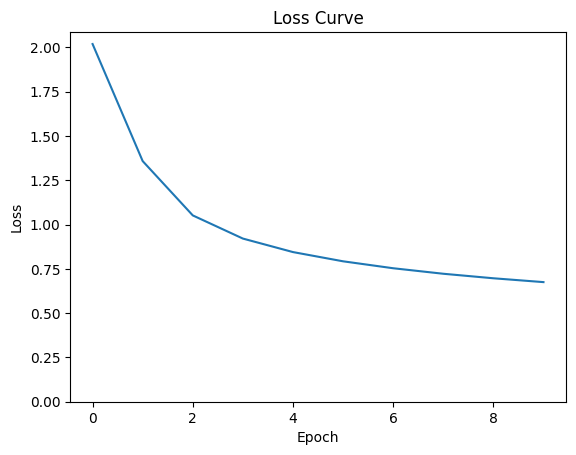

In [9]:
model_coco.plot_loss()

In [11]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.tanh1 = nn.Tanh()
        self.max1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.tanh2 = nn.Tanh()
        self.max2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 7 * 7, 50) 
        self.tanh3 = nn.Tanh()
        self.fc2 = nn.Linear(50, 10)
        

    def forward(self, x):
       
        x = self.conv1(x)
      
        x = self.tanh1(x)
      
        x = self.max1(x)
        
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.max2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.tanh3(x)
        x = self.fc2(x)
        
        return x

# Transform for normalizing the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5
])

# Load the FashionMNIST dataset from torchvision
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and test datasets
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

# Instantiate the model, loss function, and optimizer
model = FashionMNISTModel()
criterion = nn.CrossEntropyLoss()  # Use raw class labels for CrossEntropyLoss
optimizer = optim.SGD(model.parameters(), lr=0.001)


100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [12]:

# Training loop

def train_model(model, train_loader, epochs, optimizer, criterion):
    model.train()  # Set model to training mode
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero gradients
          
            outputs = model(images)
        
            
            loss = criterion(outputs, labels)  # Labels are in class indices format
          
            loss.backward()
        
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}')

# Testing loop

train_model(model, train_loader, epochs=10, optimizer=optimizer, criterion=criterion)

# Test the model on test data



Epoch 1/10, Loss: 2.1982
Epoch 2/10, Loss: 1.7270
Epoch 3/10, Loss: 1.3336
Epoch 4/10, Loss: 1.1233
Epoch 5/10, Loss: 0.9883
Epoch 6/10, Loss: 0.8974
Epoch 7/10, Loss: 0.8346
Epoch 8/10, Loss: 0.7887
Epoch 9/10, Loss: 0.7532
Epoch 10/10, Loss: 0.7244


In [13]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

test_model(model, test_loader)

Test Accuracy: 75.22%
